# Installation
This notebook requires the following sample jobs to be present in the database. 
```
	 CM4_piControl_C_atmos_level_00050101
	 CM4_piControl_C_atmos_level_00100101
	 CM4_piControl_C_atmos_level_00150101
	 CM4_piControl_C_atmos_level_00200101
	 CM4_piControl_C_atmos_level_00250101
```

If you haven't done so yet, please **epmt submit** those directories to the database of your choice from the shell. See **README.md**:

```
$ cd OutliersData
$ ./extract.sh
$ cd ..
$ ./epmt submit OutliersData/*.dir
```

# Configuration

* Import the needed modules
* Modify any settings

After this runs we have a fully bound database model.

In [148]:
from models import *
from epmt_job import setup_orm_db
import settings
print(settings.db_params)

# Lets use the host 'db'

settings.db_params["host"] = "db"
setup_orm_db(settings)

# Set up graphing and analytics

from matplotlib import rcParams
%matplotlib inline
rcParams['figure.figsize'] = [14, 6]
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


{'provider': 'postgres', 'user': 'postgres', 'password': 'example', 'host': 'db', 'dbname': 'EPMT'}


# Browse the Database

List jobs in the database that match a **component**. Let's also print their duration and start time.


In [139]:
js = select(j for j in Job if j.ppr.component == "atmos_level")[:]
for j in js:
    print("\t",j.jobname,j.duration/1.0e6,j.start)
print(len(js[:]),"jobs found")


	 CM4_piControl_C_atmos_level_00050101 7618.369066 2019-02-20 19:58:41.714446
	 CM4_piControl_C_atmos_level_00100101 8948.181983 2019-02-21 04:41:56.596528
	 CM4_piControl_C_atmos_level_00150101 8227.289876 2019-02-21 08:22:12.046131
	 CM4_piControl_C_atmos_level_00200101 4826.598722 2019-02-21 15:12:27.619713
	 CM4_piControl_C_atmos_level_00250101 8548.81482 2019-02-22 15:00:09.280291
5 jobs found


# Extract the Data

From the bound DB objects to Python lists and Pandas DataFrames. The following is quite inefficient!

In [140]:
# Turn then into python lists

jobobjs = [j for j in js]
durations = [j.duration for j in js]
names = [j.jobname for j in js]
starts = [j.start for j in js]
numprocs = [len(j.processes) for j in js]

# Turn lists into a Pandas Dataframe, with rows and columns

df = pd.DataFrame({'job_object':jobobjs, 'duration':durations, 'starttime':starts, "numprocs":numprocs})
df

,job_object,duration,starttime,numprocs
0,Job['20345340.moab01.princeton.rdhpcs.noaa.gov'],7.618369e+09,2019-02-20 19:58:41.714446,46237
1,Job['20348694.moab01.princeton.rdhpcs.noaa.gov'],8.948182e+09,2019-02-21 04:41:56.596528,46237
2,Job['20349537.moab01.princeton.rdhpcs.noaa.gov'],8.227290e+09,2019-02-21 08:22:12.046131,46237
3,Job['20352721.moab01.princeton.rdhpcs.noaa.gov'],4.826599e+09,2019-02-21 15:12:27.619713,54166
4,Job['20362929.moab01.princeton.rdhpcs.noaa.gov'],8.548815e+09,2019-02-22 15:00:09.280291,46237


# Find Outliers

## By Job Wallclock Duration or Total Process Count

### Visually

Look at duration and process count of Jobs using a boxplot.

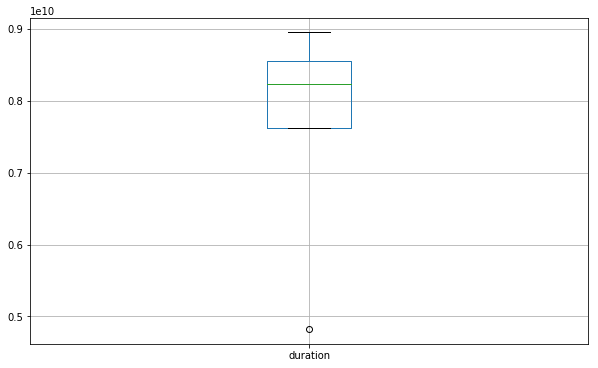

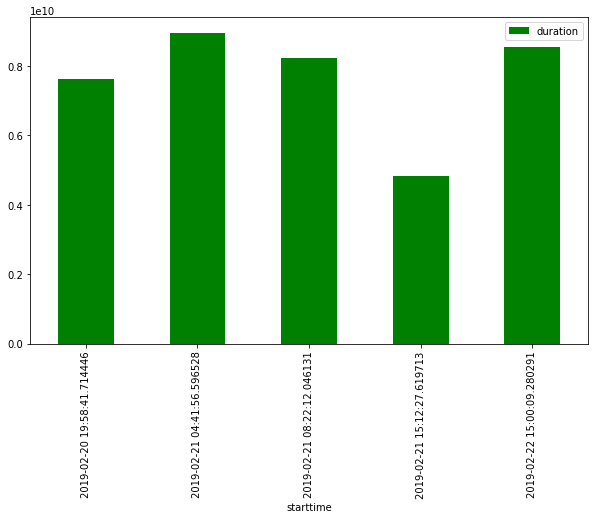

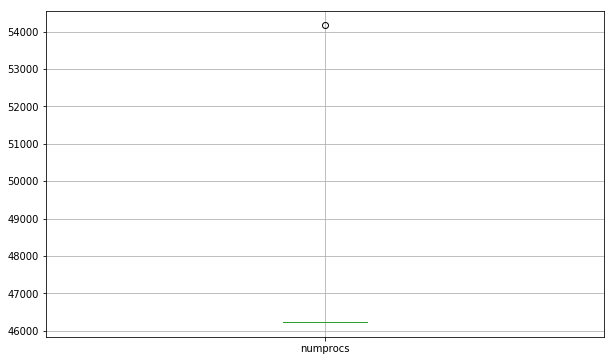

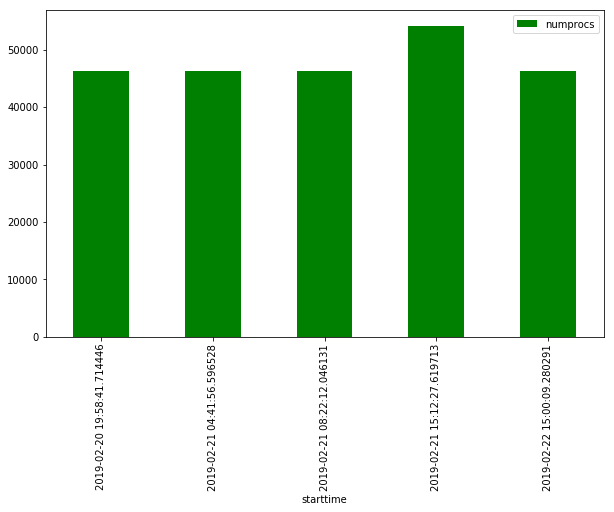

In [141]:
df.boxplot(column=['duration'])
plt.show()
df.plot.bar(x='starttime',y='duration',color='g')
plt.show()
df.boxplot(column=['numprocs'])
plt.show()
df.plot.bar(x='starttime',y='numprocs',color='g')
plt.show()


## Computationally using IQR

Define helper functions to identify and separate our outliers.

In [142]:
def outliers_z_score(ys):
    threshold = 3
    mean_y = ys.mean()
    stdev_y = ys.std()
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return ys.where(z_scores > threshold)
def outliers_modified_z_score(ys):
    threshold = 3.5
    median_y = ys.median()
    median_absolute_deviation_y = ys.mad()
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                         for y in ys]
    return ys.where(np.abs(modified_z_scores) > threshold)
def outliers_iqr(ys):
    quartile_1, quartile_3 = ys.quantile(q=[.25, .75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
#    print(iqr,lower_bound,upper_bound)
    return ys.where((ys < lower_bound) | (ys > upper_bound))
def get_outliers(df,column,func=outliers_iqr):
    outliers = func(df[column])
    odf = df[outliers > 0].reset_index(drop=True)
    gdf = df[outliers.isnull() == True].reset_index(drop=True)
    return(gdf,odf)

# We could look at outliers for any field
good,outliers = get_outliers(df,"numprocs")
print(outliers)

# But lets do duration
good,outliers = get_outliers(df,"duration")
print(outliers)



                                         job_object      duration  \
0  Job['20352721.moab01.princeton.rdhpcs.noaa.gov']  4.826599e+09   

                   starttime  numprocs  
0 2019-02-21 15:12:27.619713     54166  
                                         job_object      duration  \
0  Job['20352721.moab01.princeton.rdhpcs.noaa.gov']  4.826599e+09   

                   starttime  numprocs  
0 2019-02-21 15:12:27.619713     54166  


# Deeper Examination of an Outlier

Let's compare the number and duration of executables present in this job versus the good jobs. First let's fetch all the duration data for all the processes of this job.

## Gathering Process Information

Lets gather up information about the processes in our suspected outlier


In [187]:
j = outliers.job_object[0]
procobjs = [p for p in j.processes]
exenames = [p.exename for p in j.processes]
starts = [p.start for p in j.processes]
durations = [p.duration for p in j.processes]
jobobjs = [p.job for p in j.processes]
odf = pd.DataFrame({'process':procobjs, 'exename':exenames, 'duration':durations, 'start':starts, 'job':jobobjs})
# Put in time order
odf = odf.sort_values("start")
print(len(odf),"processes in",j) 

54166 processes in Job['20352721.moab01.princeton.rdhpcs.noaa.gov']


And now do the same for our **good** jobs.


In [188]:
procobjs=[]
exenames=[]
starts=[]
durations=[]
jobobjs=[]

for j in good.job_object:
    print(j)
    for p in j.processes:
        procobjs.append(p)
        exenames.append(p.exename)
        starts.append(p.start)
        durations.append(p.duration)
        jobobjs.append(p.job)

gdf = pd.DataFrame({'process':procobjs, 'exename':exenames, 'duration':durations, 'start':starts, 'job':jobobjs})
# Put in time order
gdf = gdf.sort_values("start")
print(len(gdf),"processes in good jobs") 


Job['20345340.moab01.princeton.rdhpcs.noaa.gov']
Job['20348694.moab01.princeton.rdhpcs.noaa.gov']
Job['20349537.moab01.princeton.rdhpcs.noaa.gov']
Job['20362929.moab01.princeton.rdhpcs.noaa.gov']
184948 processes in good jobs


## Look at Execution Profile by Binary

Outlier:  Job['20352721.moab01.princeton.rdhpcs.noaa.gov']


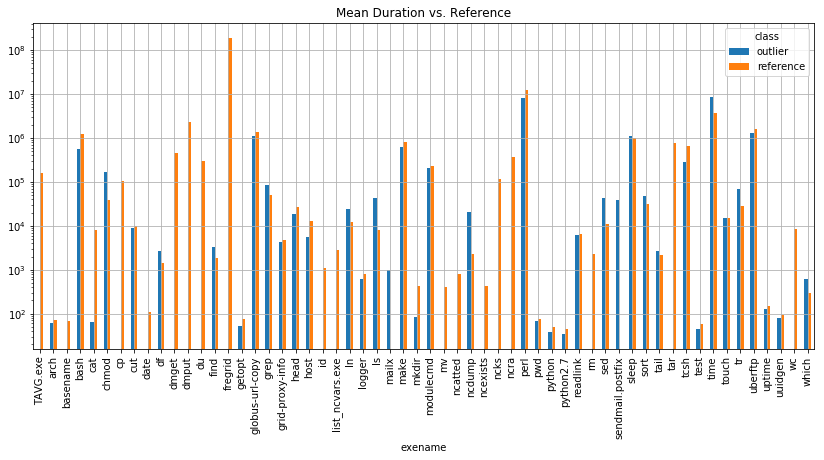

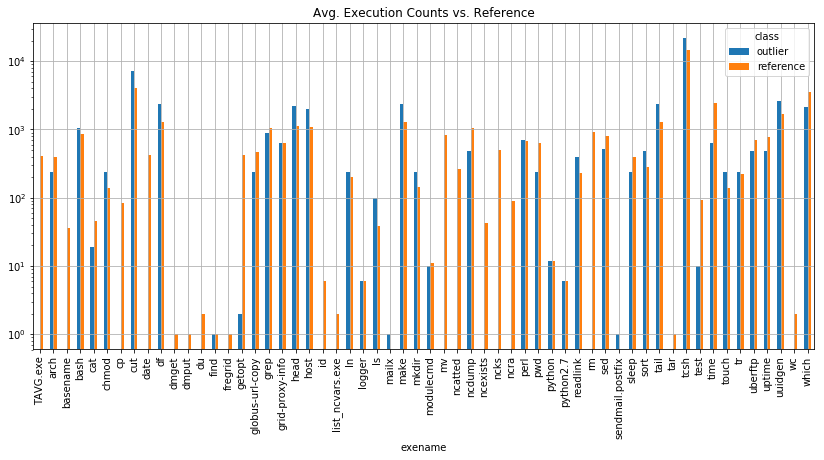

	 TAVG.exe was never executed
	 basename was never executed
	 cp was never executed
	 date was never executed
	 dmget was never executed
	 dmput was never executed
	 du was never executed
	 fregrid was never executed
	 id was never executed
	 list_ncvars.exe was never executed
	 mv was never executed
	 ncatted was never executed
	 ncexists was never executed
	 ncks was never executed
	 ncra was never executed
	 rm was never executed
	 tar was never executed
	 wc was never executed
	 mailx was unexpectedly executed
	 sendmail.postfix was unexpectedly executed


In [195]:
print("Outlier: ",outliers.job_object[0])
newodf = odf.copy()
newodf["class"] = "outlier"
newgdf = gdf.copy()
newgdf["class"] = "reference"
fulldf = newgdf.append(newodf)
#print(fulldf.head())
#print(fulldf.tail())
fulldf.groupby(['exename', 'class'])['duration'].mean().unstack().plot.bar(grid=True)
plt.yscale('log')
plt.title("Mean Duration vs. Reference")
plt.show()

def get_avg_counts_exes(idf):
    exesinjob = {}
    execnt = {}
    for index, row in idf.iterrows():
        exe = row['exename']
        job = row['job']
        if exe not in exesinjob:
            exesinjob[exe] = [job]
            execnt[exe] = 1
        elif job not in exesinjob[exe]:
            exesinjob[exe].append(job)
            execnt[exe] += 1
        else:
            execnt[exe] += 1
    avgcounts=[]
    for k in sorted(exesinjob.keys()):
#        print(k)
        avgcounts.append(execnt[k]/len(exesinjob[k]))
    return(list(sorted(exesinjob.keys())),avgcounts)
#    print(k,execnt[k],avgcounts[k])

exes,avgcs = get_avg_counts_exes(gdf)
pdac = pd.DataFrame({"exename":exes, "avgcount":avgcs, "class":"reference"})
#print(pdac.tail())
exes,avgcs = get_avg_counts_exes(odf)
pdac = pdac.append(pd.DataFrame({"exename":exes, "avgcount":avgcs, "class":"outlier"}))
#print(pdac.tail())
pdac.groupby(['exename', 'class'])['avgcount'].mean().unstack().plot.bar(grid=True)
#print(fulldf.groupby(['exename', 'class']).size().mean())
plt.yscale('log')
plt.title("Avg. Execution Counts vs. Reference")
plt.show()

g_groupby = gdf.groupby(['exename'])
o_groupby = odf.groupby(['exename'])
for e in g_groupby.groups.keys():
    if e not in o_groupby.groups.keys():
        print("\t",e,"was never executed")
for e in o_groupby.groups.keys():
    if e not in g_groupby.groups.keys():
        print("\t",e,"was unexpectedly executed")




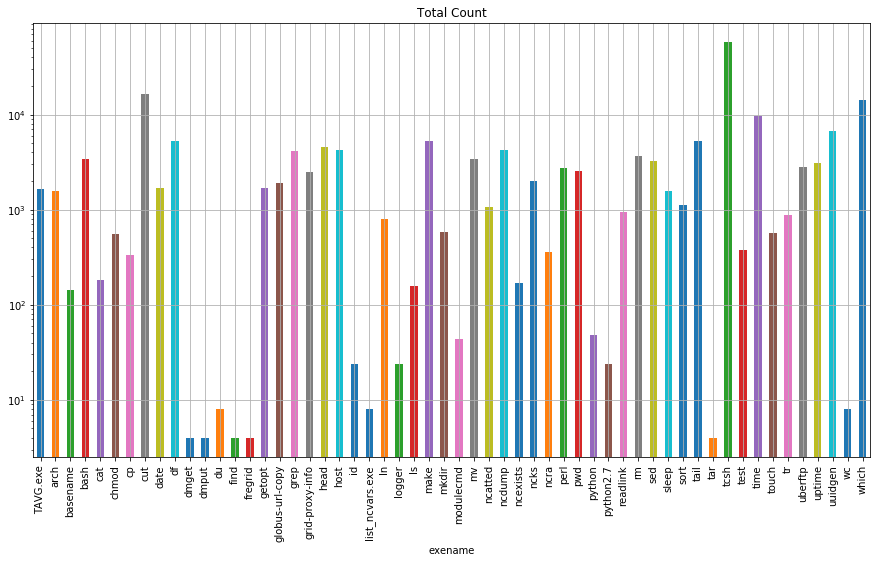

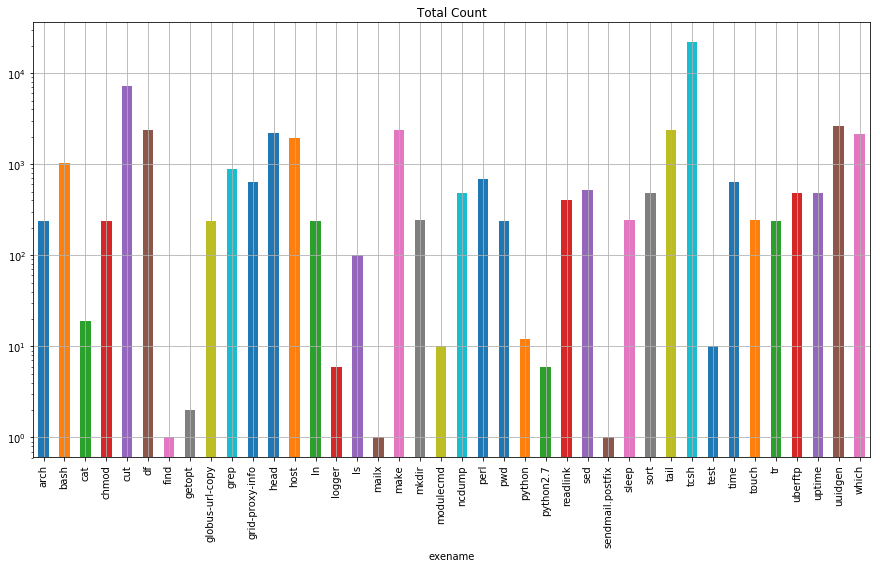

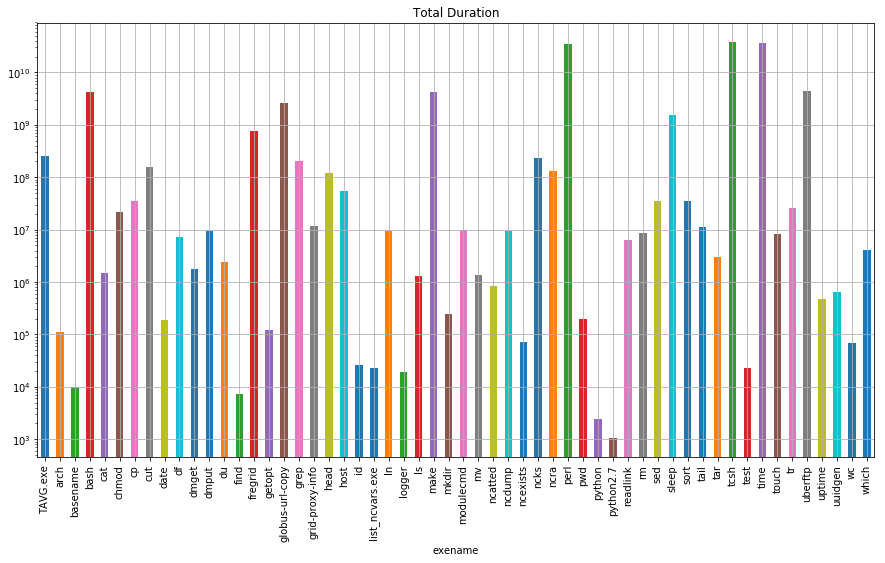

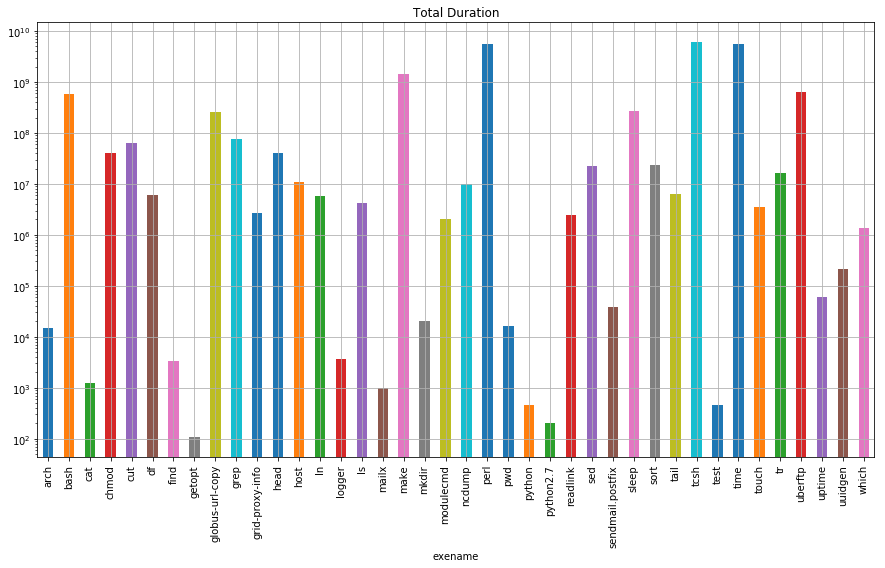

In [70]:

def plot_logy_histogram(series,title=""):
    series.plot.bar(grid=True)
    plt.yscale('log')
    plt.title(title)
    plt.show()

groupby = gdf.groupby(['exename'])["duration"]
plot_logy_histogram(groupby.agg("count"),title="Total Count")
groupby = odf.groupby(['exename'])["duration"]
plot_logy_histogram(groupby.agg("count"),title="Total Count")

#df.groupby(['exename'])["duration"].agg("sum"))
groupby = gdf.groupby(['exename'])["duration"]
plot_logy_histogram(groupby.agg("sum"),title="Total Duration")
groupby = odf.groupby(['exename'])["duration"]
plot_logy_histogram(groupby.agg("sum"),title="Total Duration")
#plt.gca().set_yscale("log")
#lt.title("Duration by Executable in Range")


#.plot(kind='bar')
#df.apply(pd.value_counts).plot(kind='bar', subplots=True)
#series = pd.Series(durations)
#plot_logx_histogram(series)
#plt.title("Duration Histogram")
#plt.show()



What about just those that ran longer than 10 seconds? 

284 processes ran longer than 10s
time               92
perl               90
uberftp            21
bash               21
globus-url-copy    21
tcsh               19
make               18
fregrid             2
Name: exename, dtype: int64


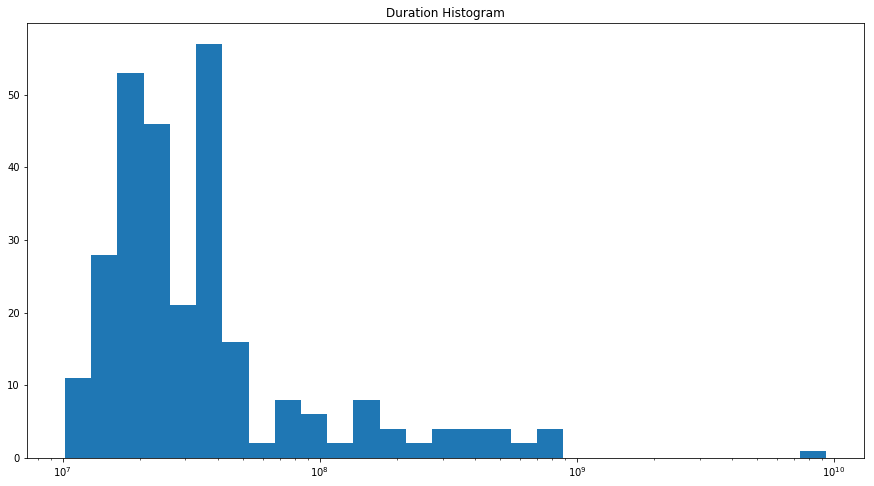

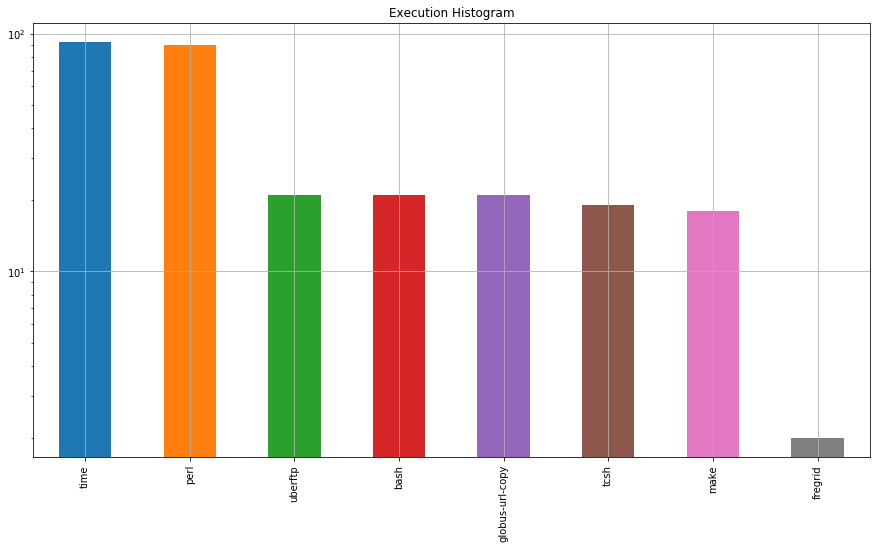

In [168]:
newdf = df[df.duration > 10000000].copy()
print(len(newdf),"processes ran longer than 10s")
print(newdf.exename.value_counts())
plot_logx_histogram(newdf.duration)
plt.title("Duration Histogram")
plt.show()
plot_logy_histogram(newdf.exename.value_counts())
plt.title("Execution Histogram")
plt.show()

Lets plot the sum contributions of the executables in this range

exename
bash               4.723779e+08
fregrid            2.987324e+08
globus-url-copy    4.490358e+08
make               4.443542e+08
perl               8.229228e+09
tcsh               9.729624e+09
time               8.532000e+09
uberftp            4.819701e+08
Name: duration, dtype: float64


Text(0.5,1,'Duration by Executable in Range')

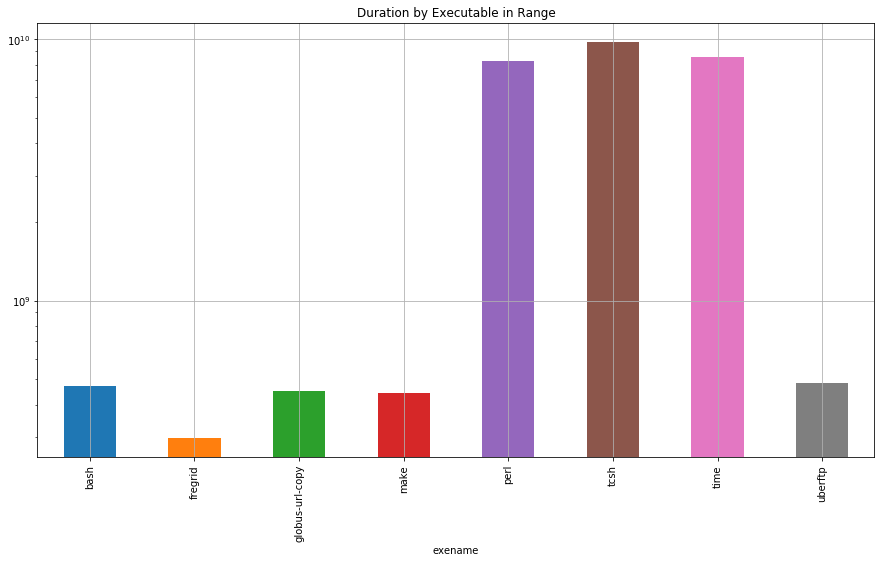

In [169]:
#print(newdf.groupby(['exename'])["duration"].describe())
print(newdf.groupby(['exename'])["duration"].agg("sum"))
newdf.groupby(['exename'])["duration"].agg("sum").plot.bar(grid=True)
plt.gca().set_yscale("log")
plt.title("Duration by Executable in Range")


Let's examine the duration of the perl executable as this takes a lot of time.

90 runs of perl
194 runs of not perl


Text(0.5,1,'Not Perl: Start Time vs. Duration in Range')

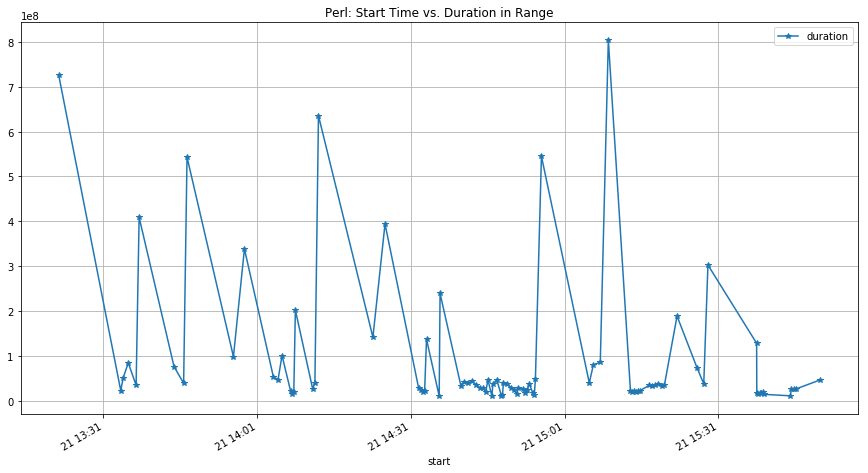

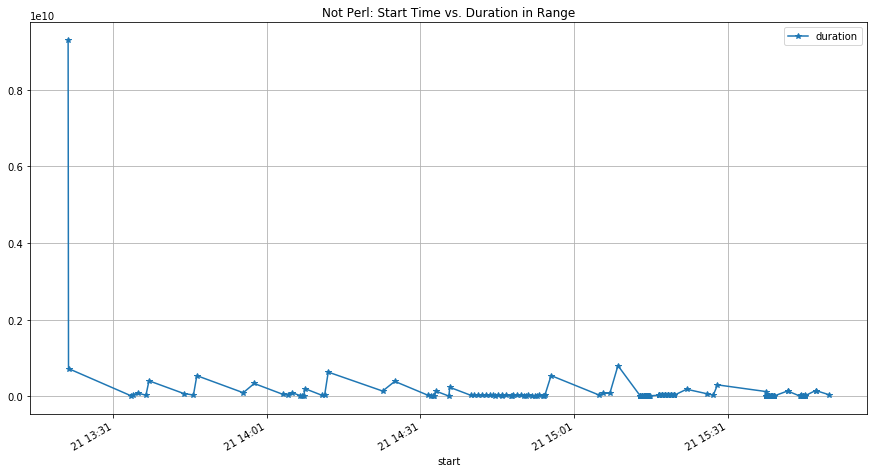

In [170]:
cutonly = newdf[newdf['exename'] == 'perl']
print(len(cutonly),"runs of perl")
cutonly.sort_values(by=["start"]).plot(x='start', y='duration', style="-*", grid=True)
plt.title("Perl: Start Time vs. Duration in Range")
#print(cutonly.sort_values(by=["start"]))

cutonly2 = newdf[newdf['exename'] != 'perl']
print(len(cutonly2),"runs of not perl")
cutonly2.sort_values(by=["start"]).plot(x='start', y='duration', style="-*", grid=True)
plt.title("Not Perl: Start Time vs. Duration in Range")
#print(cutonly2.sort_values(by=["start"]))


Dig into the binaries and find out what's happening. Define a function to get us the metrics of a single process and its threads. Let's use it to look at the few > 70s instances.

In [171]:
def get_process_metrics(po):
    meas = {}
    # Iterate over the metrics over all threads and make a list of value and thread, hashed by metricname
    for m in po.threads.metrics:        
        if m.metricname.name not in meas:
            meas[m.metricname.name] = [ (m.value, m.thread) ]
        else:
            meas[m.metricname.name].append( (m.value, m.thread) )
    # Make a dataframe out of it and always insert columns in same order
    df = pd.DataFrame()
    for k in sorted(meas):
        v,t = zip(*meas[k])
        if 'thread' not in df.columns:
            df['thread'] = t
        df[k] = v
    return df

BAD=cutonly[cutonly.duration > 700000000]
print(BAD)
print()

# For each process object, lets look at the metrics
plist = []
for p in BAD.process:
    pdf = get_process_metrics(p)
    plist.append(pdf)
    print(pdf)

cputime1 = plist[0]['systemtime'][0]+plist[0]['usertime'][0]
cputime2 = plist[1]['systemtime'][0]+plist[1]['usertime'][0]
print(plist[0].thread[0].process.exename,plist[0].thread[0].process.duration,"vs",cputime1)
print(plist[1].thread[0].process.exename,plist[1].thread[0].process.duration,"vs",cputime2)

      exename     duration                      start         process
923      perl  804311348.0 2019-02-21 15:09:33.156059  Process[87419]
33812    perl  726977548.0 2019-02-21 13:22:16.692514  Process[88400]

          thread  PERF_COUNT_SW_CPU_CLOCK  cancelled_write_bytes  \
0  Thread[98737]              780663475.0                    0.0   

   delayacct_blkio_time  guest_time  inblock  invol_ctxsw  majflt   minflt  \
0               10000.0         0.0     16.0          6.0     0.0  11502.0   

   num_threads     ...       syscr  syscw  systemtime    time_oncpu  \
0          1.0     ...       560.0  147.0    886865.0  1.028530e+09   

   time_waiting  timeslices  usertime  vol_ctxsw     wchar  write_bytes  
0      868551.0     34499.0  140978.0    34492.0  183484.0     536576.0  

[1 rows x 27 columns]
          thread  PERF_COUNT_SW_CPU_CLOCK  cancelled_write_bytes  \
0  Thread[99880]              687553198.0                    0.0   

   delayacct_blkio_time  guest_time  inblock

So, these processes were never actually running during their lifetime. No surprise there really. We would then dig further in the process tree using the **ppid** and **pid** fields.

Let's define more helper functions for queries. There are much much easier ways of doing this. But this suffices for now.

In [172]:
def get_job_list():
    q = select(j for j in Job)
    return q[:]
    
# Return list of objects for jobid

def get_processes_job(jobid):
    # lookup job
    try:
        j = Job[jobid]
    except Exception as e:
        print("not found",e)
        return None
    print("Found job",jobid,"with",len(j.processes),"processes and",len(j.processes.threads),"threads")
    return j.processes
    
# Reduce all processes by executable name and return sums of metric

    # we could do this with a query, maybe
    # processes=select((p.exename, sum(p.duration), count(p)) for p in Process if p.job == j).order_by(-2)
    #    for p in processes:
    #        threads += p.threads

def get_job_processes_reduce_attr(jobid, attr_name, cutoff=0.0, exelen=10):
    processes = get_processes_job(jobid)
    if not processes:
        return
    proc_dict={}
    total = 0.0
    for p in processes:
        exename = p.exename[:exelen]
        if exename not in proc_dict:
            proc_dict[exename] = {}
            proc_dict[exename]["count"] = 1
            proc_dict[exename]["threads"] = len(p.threads)
            proc_dict[exename][attr_name] = getattr(p, attr_name)
        else:
            proc_dict[exename]["count"] += 1
            proc_dict[exename]["threads"] += len(p.threads)
            proc_dict[exename][attr_name] += getattr(p, attr_name)
        total += getattr(p, attr_name)
    
    if cutoff > 0.0:
        for key in list(proc_dict):
            if proc_dict[key][attr_name] < cutoff:
                del proc_dict[key]
       
    return (total, proc_dict)

# Reduce all processes by executable name and return sums of metric

def get_job_processes_full_attr(processes, attr_name, cutoff=0.0, exelen=10):
    proc_dict={}
    total = 0.0
    for p in processes:
        exename = p.exename[:exelen] 
        if exename not in proc_dict:
            proc_dict[exename] = {}
            proc_dict[exename][attr_name] = [getattr(p, attr_name)]
            proc_dict[exename]["start"] = [getattr(p, "start")]                     
        else:
            proc_dict[exename][attr_name].append(getattr(p, attr_name))
            proc_dict[exename]["start"].append(getattr(p, "start"))
        total += getattr(p, attr_name)
    
    if cutoff > 0.0:
        for key in proc_dict.keys():
            if proc_dict[key][attr_name] < cutoff:
                del proc_dict[key]
       
    return (total, proc_dict)

List all the jobs and whether they are a Post Processing Run

In [173]:
# All this does is select(j for j in Job)[:]

js = get_job_list() 
for j in js:
    print(j.jobid,"from",j.start,"to",j.end,"by",j.user.name,"took",j.duration/1e6,"s.")
    if j.ppr:
        print("\t","Post-processing run, job.name:",j.jobname)
        print("\t","Post-processing run, ppr.component:",j.ppr.component)
        print("\t","Post-processing run, ppr.name:",j.ppr.name)
        print("\t","Post-processing run, ppr.jobname:",j.ppr.jobname)
        print("\t","Post-processing run, ppr.oname:",j.ppr.oname)


20345339.moab01.princeton.rdhpcs.noaa.gov from 2019-02-20 19:58:41.274267 to 2019-02-20 22:13:23.131187 by Jeffrey.Durachta took 8081.85692 s.
	 Post-processing run, job.name: CM4_piControl_C_atmos_00050101
	 Post-processing run, ppr.component: atmos
	 Post-processing run, ppr.name: CM4_piControl_C
	 Post-processing run, ppr.jobname: CM4_piControl_C_atmos_00050101
	 Post-processing run, ppr.oname: 00050101
20348693.moab01.princeton.rdhpcs.noaa.gov from 2019-02-21 04:41:56.433031 to 2019-02-21 06:55:04.301253 by Jeffrey.Durachta took 7987.868222 s.
	 Post-processing run, job.name: CM4_piControl_C_atmos_00100101
	 Post-processing run, ppr.component: atmos
	 Post-processing run, ppr.name: CM4_piControl_C
	 Post-processing run, ppr.jobname: CM4_piControl_C_atmos_00100101
	 Post-processing run, ppr.oname: 00100101
19062 from 2019-03-12 22:24:21.725973 to 2019-03-12 22:24:32.743850 by phil took 11.017877 s.
20349536.moab01.princeton.rdhpcs.noaa.gov from 2019-02-21 08:22:11.444810 to 2019-02-

Lets just grab the first job here and plot some of its attributes

Found job 20345339.moab01.princeton.rdhpcs.noaa.gov with 37464 processes and 42314 threads


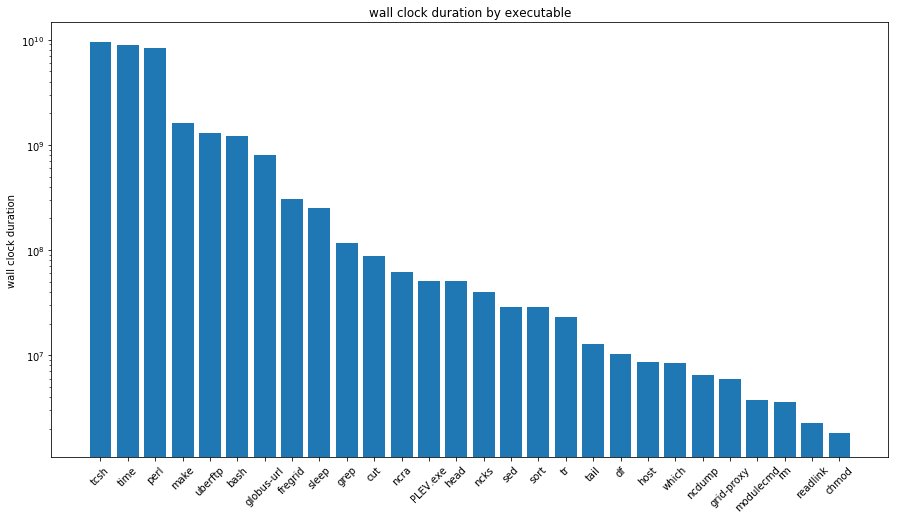

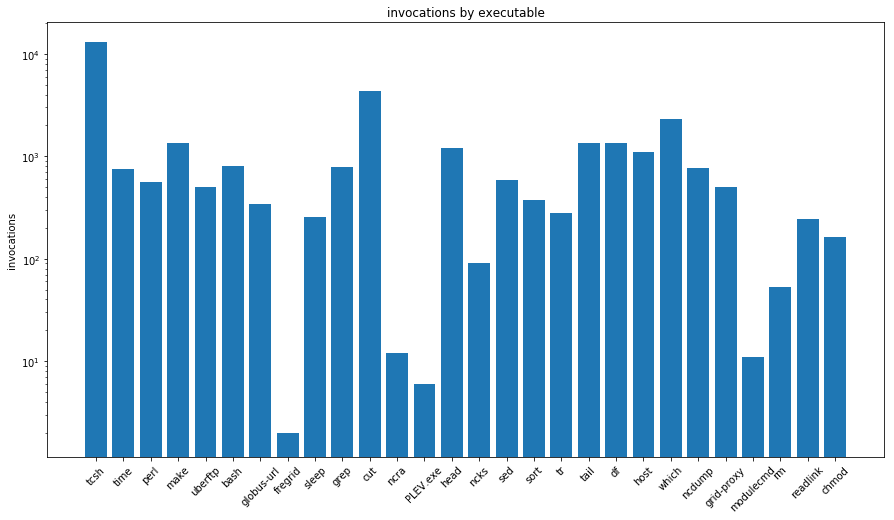

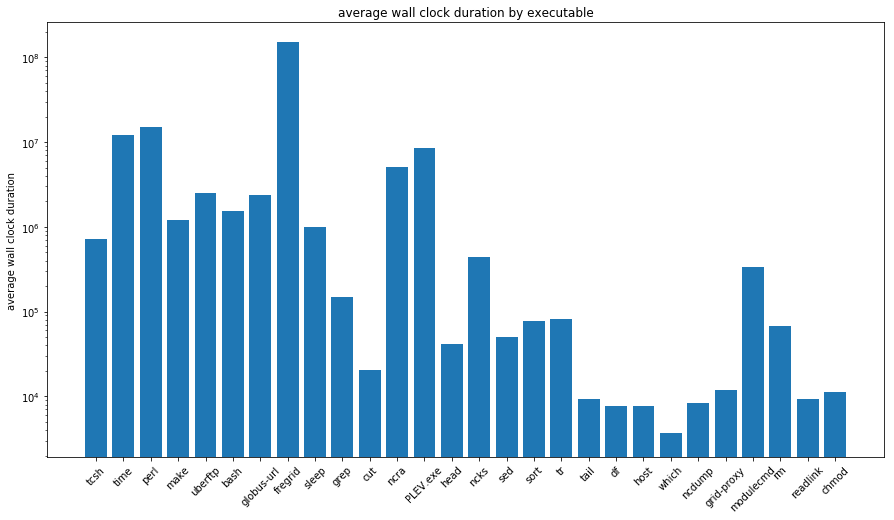

In [174]:
j = js[0].jobid
total, proc_dict = get_job_processes_reduce_attr(jobid=j, attr_name='duration', cutoff=1000000.0)
labels = []
y_val = []
y_val2 = []
y_val3 = []
labels = sorted(proc_dict.keys())
labels = sorted(proc_dict, key=lambda k: (proc_dict[k]["duration"]), reverse=True)
for k in labels:
    value = proc_dict[k]
    y_val3.append(value["duration"]/value["count"])
    y_val.append(value["duration"])
    y_val2.append(value["count"])
    
barplot(labels=labels,y_val=y_val,mn="wall clock duration")
barplot(labels=labels,y_val=y_val2,mn="invocations")
barplot(labels=labels,y_val=y_val3,mn="average wall clock duration")



Here's an example function that filters for an executables prefix

In [175]:
# Return list of objects for jobid

def get_processes_job_filter(jobid, pat=None):
    query = select ((p.exename, p.start, p.duration) for p in Process 
                    if p.job in select(j for j in Job if j.jobid == jobid)).order_by(2)
    if pat:
        query = query.filter(lambda p, q, r: p.startswith(pat))
    return query[:]

Lets scatter plot this job and the long job

20345339.moab01.princeton.rdhpcs.noaa.gov


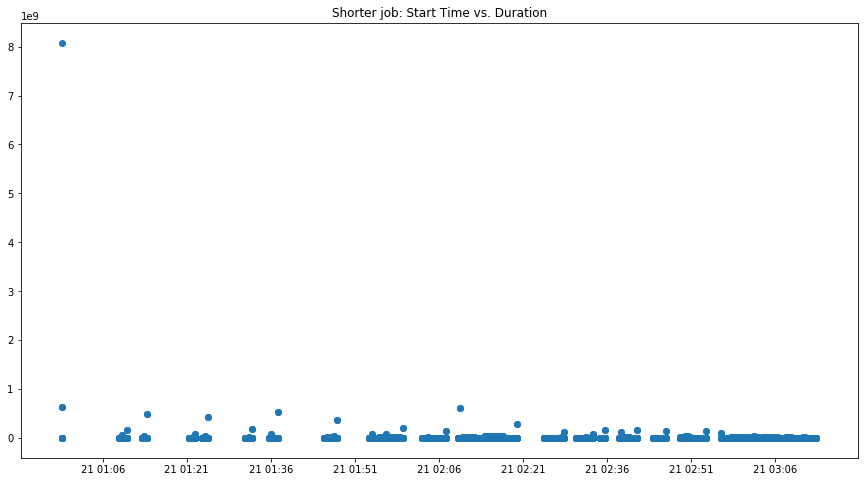

20349536.moab01.princeton.rdhpcs.noaa.gov


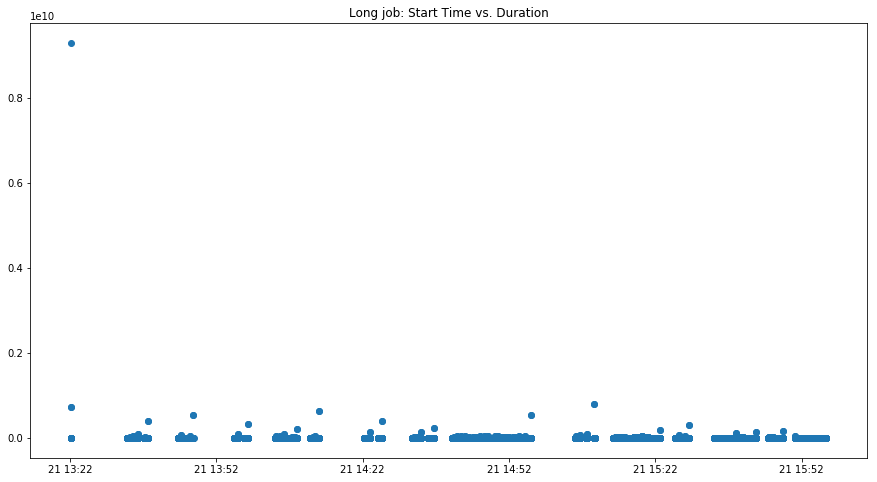

In [176]:
print(j)
a = get_processes_job_filter(j)    
#print(a)
e,t,d = zip(*a)
plt.plot([],[])
plt.scatter(t,d)
#plt.gcf().autofmt_xdate()
plt.title("Shorter job: Start Time vs. Duration")
plt.show()

print(jlong)
a = get_processes_job_filter(jobid=jlong)    
#print(a)
e,t,d = zip(*a)
plt.plot([],[])
plt.scatter(t,d)
#plt.gcf().autofmt_xdate()
plt.title("Long job: Start Time vs. Duration")
plt.show()



Let's examine metrics of interest

In [ ]:
tofind = [ "read_bytes", "write_bytes", "rchar", "wchar", "delayacct_blkio_time", 
          "usertime", "invol_ctxsw", "time_oncpu", "time_waiting", "systemtime", "rdtsc_duration" ]

# This function gets all metrics and Thread(primary key) in all input JIDS that match EXE
# Input: list of JIDS and exename
# Output: DataFrame with 'thread' and N columns of metrics

def get_df_all_process(jids,exe):
    q = Process.select(lambda p: p.job in jids and p.exename==exe).without_distinct()
#    print "exe",exe,"ran",len(q),"times"
    q = select(p.threads.metrics for p in q).without_distinct()
# order by is important as it always produces the same order of threads
    q = select((m.value,m.metricname.name,m.thread) for m in q).without_distinct().order_by(3)
# make lists
    meas = {}
    for m in q[:]:
        if m[1] not in meas:
            meas[m[1]] = [ (m[0], m[2]) ]
        else:
            meas[m[1]].append( (m[0], m[2]) )
# make df
    df = pd.DataFrame()
    for k in tofind:
        if k in meas:
            v,t = zip(*meas[k])
            df[k] = v
            if 'thread' not in df.columns:
                df['thread'] = t
    return df

# This function develops filtering/outlier criteria from a set of jobs, by executable
# Input: List of JIDS
# Output: Dictionary by exe of statistical data for each metric (mean/stddev/etc)

def get_filter_criteria(by_jids):
# First compute averages of filter/reference jobs
    q1 = Process.select(lambda p: p.job in by_jids).without_distinct()
    q1 = select(p.exename for p in q1).order_by(1) #.without_distinct()
    criteria = {}
    for exe in q1[:]:
        df = get_df_all_process(by_jids,exe)
        print(exe,"found",len(df),"times")
        criteria[exe] = df.describe()
#        outlier_dfs=[]
#        outlier_procs=[]
#        for metric in tofind:
            #       print len(df[metric])
#            b = get_outliers_by_quantile(df[['thread',metric]].copy(),metric)
            #       print len(b)
            #print_outliers(b,metric)
#            outlier_dfs.append(b)
#            for index, row in b.iterrows():
#                outlier_procs.append(row['thread'].process)
        #print "Processes with more than one outlier"
        #procs,metrics = zip(*outlier_procs)
#        procs = outlier_procs
#        dfvc = pd.DataFrame({'thread': procs})
#        vc = dfvc['thread'].value_counts()
#        vc = vc[ vc != 1]
#        for index, value in vc.iteritems():
#            print index,index.exename,"on",index.host.name,"at",index.start,"for",index.duration
#        if len(vc):
#            vc.plot.bar(subplots=True,title=index.exename+" processes with > 1 outlier",color=['darkblue'])
#            plt.show()
# FIX:      We should record which outlier(s) for each process!
#            pass
#        newdf = df
#        for d in outlier_dfs:
#            newdf = remove_outliers(newdf,d)
#        print df.describe()
    return criteria
#
# If we get here, we now have, by executable, a set of criteria to filter the input jobs
#
# Criteria is a dict [exe][metric]["std" or "dev"]
# Should be an object with a method

def filter_jobs(jids,exe_criteria,zscore_threshold=3.0):
    q1 = Process.select(lambda p: p.job in jids).without_distinct()
    q1 = select(p.exename for p in q1).order_by(1) #.without_distinct()
    criteria = {}
    for exe in q1[:]:
        df = get_df_all_process(jids,exe)
        print(exe,"found",len(df),"times")
        # create dataframe for zscores for this exe, all metrics
        zscores = pd.DataFrame(columns=tofind)
#        zscores['thread'] = df['thread']
        # for each column/metric
        for column in df:
            if column == 'thread':
                continue
            metric = column
            if metric not in tofind:
                continue
            if exe not in exe_criteria:
                continue
            mean = exe_criteria[exe][metric]["mean"]
            std = exe_criteria[exe][metric]["std"]
            if mean == 0 and (std == 0 or std == pd.np.nan):
#                print metric,exe,"mean is 0 or std is 0/Nan, skipping"
                zscores[metric] = pd.Series(False, index=df.index)
                continue
#            print "checking",len(df),exe,"metric",metric,"against mean",mean,"stddev",std
# Z-score (X-mu)/sigma
            zscores[column] = (abs(df[column] - mean)/std > zscore_threshold)
# Does any row have a True?    
        zs = zscores.any(axis='columns')
# Which ones?
        indices = zs[zs == False].index
# Drop non-outliers
        df.drop(indices, inplace=True)
        zscores.drop(indices,inplace=True)
        print("*** ",exe,"has",len(df),len(zscores),"with outliers ***")
#        for index, row in df.iterrows():
#            print(row)
#            print(zscores.loc[index, :])

    return False, False

#criteria = get_filter_criteria([js[0]])        
#outliers, outlier_metrics = filter_jobs([js[0]],criteria)
#print(outlier_metrics)



# Handle jobs of a type of experiment

In [181]:
# 
# Lets snarf up a few jobs of atmos_level and use them to filter the last one
#
ref_jobs=[]
js = get_job_list()
for j in js:
    if j.ppr and j.ppr.component == "atmos_level":
        print(j.jobid,"("+j.ppr.component+")","from",j.start,"by",j.user.name,"took",j.duration/1e6,"s.")
        ref_jobs.append(j)

# Last 
to_analyze_jobs = ref_jobs[3]
# First 3 plus last
ref = ref_jobs[:3]
#ref_jobs.append(ref_jobs[4])
print()
print("Analyzing",to_analyze_jobs,"vs.",ref_jobs)

20345340.moab01.princeton.rdhpcs.noaa.gov (atmos_level) from 2019-02-20 19:58:41.714446 by Jeffrey.Durachta took 7618.369066 s.
20348694.moab01.princeton.rdhpcs.noaa.gov (atmos_level) from 2019-02-21 04:41:56.596528 by Jeffrey.Durachta took 8948.181983 s.
20349537.moab01.princeton.rdhpcs.noaa.gov (atmos_level) from 2019-02-21 08:22:12.046131 by Jeffrey.Durachta took 8227.289876 s.
20352721.moab01.princeton.rdhpcs.noaa.gov (atmos_level) from 2019-02-21 15:12:27.619713 by Jeffrey.Durachta took 4826.598722 s.
20362929.moab01.princeton.rdhpcs.noaa.gov (atmos_level) from 2019-02-22 15:00:09.280291 by Jeffrey.Durachta took 8548.81482 s.

Analyzing Job['20352721.moab01.princeton.rdhpcs.noaa.gov'] vs. [Job['20345340.moab01.princeton.rdhpcs.noaa.gov'], Job['20348694.moab01.princeton.rdhpcs.noaa.gov'], Job['20349537.moab01.princeton.rdhpcs.noaa.gov'], Job['20352721.moab01.princeton.rdhpcs.noaa.gov'], Job['20362929.moab01.princeton.rdhpcs.noaa.gov']]


In [ ]:
criteria = get_filter_criteria(ref_jobs)
print("mean,stddev,COV of criterion for outlier detection")
for e in sorted(criteria):
    print(e)
    for m in criteria[e]:
        lms = criteria[e].loc['mean',m]
        lmsd = criteria[e].loc['std',m]
        print("\t",m,lms,lmsd,lmsd/lms)


arch found 1800 times
basename found 144 times
bash found 4488 times
cat found 199 times
chmod found 800 times
cp found 332 times


In [ ]:
# Filter our jobs by the criteria
tofind = ["usertime","systemtime","read_bytes","write_bytes","rchar","wchar","invol_ctxsw","rdtsc_duration","delayacct_blkio_time"]
def filter_jobs(jids,exe_criteria,zscore_threshold=3.0):
    outliers={}
    for exe,cdf in exe_criteria.items():
#        print(exe,"criteria",cdf['usertime']['mean'],cdf['usertime']['std'])
        df = get_df_all_process(jids,exe)
        print(exe,len(df),"executions")
        outliers[exe] = {}
        for metric in tofind:
            mean = cdf[metric]["mean"]
            std = cdf[metric]["std"]
            print("\tchecking",metric,"against mean",mean,"stddev",std)
            df[metric+"_outlier"] = (abs(df[metric] - mean)/std > zscore_threshold)
            print("\t",df[metric+"_outlier"].any())
            #zscores[metric+"_value"] = df[metric]
            #print(zscores[[metric,metric+"_value"]])
            #removed[exe] = df[df[metric+"_outlier"] == True]
        #print(df)
            outliers[exe][metric] = df[df[metric+"_outlier"] == True].copy()
        #outliers[exe] = df.copy()
    return outliers

#            print "checking",len(df),exe,"metric",metric,"against mean",mean,"stddev",std
# Z-score (X-mu)/sigma
#            
# Does any row have a True?    
#        zs = zscores.any(axis='columns')
# Which ones?
#        indices = zs[zs == False].index
# Drop non-outliers
#        df.drop(indices, inplace=True)
#        zscores.drop(indices,inplace=True)
#        print("*** ",exe,"has",len(df),len(zscores),"with outliers ***")
#        for index, row in df.iterrows():
#            print(row)
#            print(zscores.loc[index, :])

# Return values not yet supported
outliers = filter_jobs(to_analyze_jobs,criteria)
for e,od in outliers.items():
    print(e)
    for m,v in od.items():
        print("\t",m,len(v))
#    print(odf)
#print outlier_metrics

arch 390 executions
	checking usertime against mean 3878.44871795 stddev 1376.64535674
	 True
	checking systemtime against mean 4181.03589744 stddev 1176.04906021
	 True
	checking read_bytes against mean 0.0 stddev 0.0
	 False
	checking write_bytes against mean 0.0 stddev 0.0
	 False
	checking rchar against mean 55320.7282051 stddev 1.2493594694
	 False
	checking wchar against mean 0.0 stddev 0.0
	 False
	checking invol_ctxsw against mean 2.25128205128 stddev 1.13980826306
	 True
	checking rdtsc_duration against mean 248348.187179 stddev 41721.8904845
	 True
	checking delayacct_blkio_time against mean 0.0 stddev 0.0
	 False
basename 36 executions
	checking usertime against mean 3443.44444444 stddev 1132.49268542
	 False
	checking systemtime against mean 3526.77777778 stddev 1182.8805304
	 False
	checking read_bytes against mean 0.0 stddev 0.0
	 False
	checking write_bytes against mean 4096.0 stddev 0.0
	 False
	checking rchar against mean 38413.0 stddev 0.0
	 False
	checking wchar agai

getopt 419 executions
	checking usertime against mean 4714.95942721 stddev 1079.54169381
	 True
	checking systemtime against mean 2311.67541766 stddev 1051.30596826
	 False
	checking read_bytes against mean 0.0 stddev 0.0
	 False
	checking write_bytes against mean 19.5513126492 stddev 282.649239264
	 True
	checking rchar against mean 38417.2863962 stddev 0.994761949156
	 False
	checking wchar against mean 0.102625298329 stddev 1.68343115682
	 True
	checking invol_ctxsw against mean 1.06443914081 stddev 0.50181522934
	 True
	checking rdtsc_duration against mean 260617.742243 stddev 23038.6695534
	 True
	checking delayacct_blkio_time against mean 0.0 stddev 0.0
	 False
globus-url-copy 473 executions
	checking usertime against mean 884867.090909 stddev 3265849.77364
	 True
	checking systemtime against mean 164185.970402 stddev 576785.268967
	 True
	checking read_bytes against mean 25.978858351 stddev 565.002841954
	 True
	checking write_bytes against mean 150290527.256 stddev 640916506.53

	checking systemtime against mean 4979.78147268 stddev 1841.12654658
	 False
	checking read_bytes against mean 0.0 stddev 0.0
	 False
	checking write_bytes against mean 29.1876484561 stddev 344.7344363
	 True
	checking rchar against mean 54797.1294537 stddev 7551.04240466
	 False
	checking wchar against mean 4.93824228029 stddev 108.718580895
	 True
	checking invol_ctxsw against mean 2.33016627078 stddev 0.935629641507
	 False
	checking rdtsc_duration against mean 679345.605701 stddev 2643833.51564
	 True
	checking delayacct_blkio_time against mean 0.0 stddev 0.0
	 False
ncatted 267 executions
	checking usertime against mean 17554.9101124 stddev 2536.43573544
	 True
	checking systemtime against mean 8968.14606742 stddev 2479.49643755
	 True
	checking read_bytes against mean 0.0 stddev 0.0
	 False
	checking write_bytes against mean 2607.94007491 stddev 4200.60816177
	 True
	checking rchar against mean 2104415.32584 stddev 19718.790408
	 False
	checking wchar against mean 9848.80898876 s

# Appendix

In [ ]:
# Lets examine tcsh

q = Process.select(lambda p: p.job==js[0] and p.exename=="globus-url-copy").without_distinct()
q = select(p.threads.metrics for p in q).without_distinct()
q = select((m.value,m.metricname.name,m.thread) for m in q).without_distinct().order_by(3)
# order by is important as it always produces the same order of threads
meas = {}
for m in q[:]:
    if m[1] not in meas:
        meas[m[1]] = [ (m[0], m[2]) ]
    else:
        meas[m[1]].append( (m[0], m[2]) )

# Very important to be sorted by thread object here!

df = pd.DataFrame()
for k in tofind:
    if k in meas:
        v,t = zip(*meas[k])
        df[k] = v
        if 'thread' not in df.columns:
            df['thread'] = t

# TEST
#t = Thread[41211]
#print t,t.process
#print t.metrics.value
# Thread[23153] Process[20602] tcsh at 2019-02-15 18:46:10.422353 delayacct_blkio_time 10000.0
# Thread[38021] Process[33690] tcsh at 2019-02-15 18:01:31.958077 delayacct_blkio_time 2520000.0
        

outlier_dfs=[]
outlier_procs=[]
for metric in tofind:
    print
#    a = pd.DataFrame()
    b = pd.DataFrame()
    b = get_outliers(df[['thread',metric]].copy(),metric)
    print_outliers(b,metric)
    outlier_dfs.append(b)
    for index, row in b.iterrows():
            outlier_procs.append(row['thread'].process) 

#print outliers
print("Processes with more than one outlier")
dfvc = pd.DataFrame({'thread': outlier_procs})
vc = dfvc['thread'].value_counts()
vc = vc[ vc != 1]
#badboys = pd.DataFrame(columns=["key","exe","host","time","duration_us"])
for index, value in vc.iteritems():
        print(index,index.exename,"on",index.host.name,"at",index.start,"for",index.duration)
ax = vc.plot.bar(title="Processes with more than one outlier",color=['darkblue'])


newdf = df
for d in outlier_dfs:
    newdf = remove_outliers(newdf,d)

print(df.describe())
print(newdf.describe())

In [ ]:


#df = pd.DataFrame({'Duration': q[:]})
#print df.describe()
#array = [durs]
#plt.boxplot(array,showmeans=True,whis=99)
#plt.show()




In [ ]:

# Returns rows of dataframe where metric value is bigger than quantile
def get_outliers_by_quantile(pdf, metric, quantile_to_return=.999):
    cutoff = pdf[metric].quantile(q=quantile_to_return)
    return pdf[pdf[metric] > cutoff]

def print_outliers(d, metric):
    if len(d.index):
        print("\t",len(d.index),"outliers in metric",metric,"mean",d[metric].describe()["mean"]) 
    for index, row in d.iterrows():
        thr = row['thread']
        proc = thr.process
        print("\t",thr,proc,proc.exename+"("+str(proc.pid)+") at",proc.start,metric,row[metric])
        
def remove_outliers(dfi, dfol):
    dfi = dfi[~dfi.thread.isin(dfol.thread)]
    return dfi
